In [1]:
from deap import base
from deap import creator
from deap import tools
from deap import algorithms

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageDraw
import numpy as np
from skimage.metrics import structural_similarity
import cv2

import random
import numpy
import os

In [2]:
# число вершин многоугольника
POLYGON_SIZE = 10
# количество многоугольников
NUM_OF_POLYGONS = 500

# Общее число параметров для каждого многоугольника:
# 2 координаты для вершин многоугольника
# 3 числа в диапазоне [0, 255], представляющих красную, зеленую и синюю компоненты цвета многоугольника
# одно целое число в диапазоне [0, 255], представляющее альфа-канал, или степень непрозрачности, многоугольника
NUM_OF_PARAMS = NUM_OF_POLYGONS * (POLYGON_SIZE * 2 + 4)

# Константы генетического алгоритма:
# размер популяции
POPULATION_SIZE = 200
# вероятность кроссовера
P_CROSSOVER = 0.9
# вероятность мутации
P_MUTATION = 0.5 
# максимальное число поколений
MAX_GENERATIONS = 5000
# размер зала славы
HALL_OF_FAME_SIZE = 20
# коэффициент скученности
CROWDING_FACTOR = 10.0

# метод вычисления степени различия
DIFFERENCE_METHOD = "MSE"
# DIFFERENCE_METHOD = "SSIM"

# фиксированное начальное значение генератора случайных чисел:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

# верхняя и нижняя границы диапазона чисел с плавающей точкой
BOUNDS_LOW, BOUNDS_HIGH = 0.0, 1.0

In [3]:
class ImageTest:

    def __init__(self, imagePath, polygonSize):
        """
        Инициализация класса
        :imagePath: путь к оригинальному изображению
        :polygonSize: количество вершин многоугольников, из которых составляется изображение-реконструкция
        """
        self.refImage = Image.open(imagePath)
        self.polygonSize = polygonSize

        self.width, self.height = self.refImage.size
        self.numPixels = self.width * self.height
        self.refImageCv2 = self.toCv2(self.refImage)

    def polygonDataToImage(self, polygonData):
        """
        принимает список, содержащий данные многоугольников,
        разбивает этот список на части, представляющие отдельные многоугольники,
        и создает изображение, рисуя эти многоугольники на чистом холсте
        """
        # создание нового изображения
        image = Image.new('RGB', (self.width, self.height))
        draw = ImageDraw.Draw(image, 'RGBA')

        # разбиение списка на части, представляющие отдельные многоугольники
        chunkSize = self.polygonSize * 2 + 4
        polygons = self.list2Chunks(polygonData, chunkSize)

        # нанесение каждого многоугольника на изображение
        for poly in polygons:
            index = 0

            # извлекает вершины для текущего многоугольника:
            vertices = []
            for vertex in range(self.polygonSize):
                vertices.append((int(poly[index] * self.width), int(poly[index + 1] * self.height)))
                index += 2

            # извлекает значения для RGB и альфа-канала для текущего многоугольника:
            red = int(poly[index] * 255)
            green = int(poly[index + 1] * 255)
            blue = int(poly[index + 2] * 255)
            alpha = int(poly[index + 3] * 255)

            # наносит многоугольник на изображение:
            draw.polygon(vertices, (red, green, blue, alpha))
       
        del draw

        return image

    def getDifference(self, polygonData, method="MSE"):
        """
        принимает данные многоугольников, создает из них изображение
        и вычисляет различие между ним и образцом одним из двух методов:
        СКО(среднеквадратичная ошибка) или SSIM(индекс структурного сходства)
        :polygonData: лист параметров многоугольника
        :method: метод вычисления степени различия ("MSE" или "SSIM").
        :return: вычисленная степень различия между изображением-реконструкцией и оригинальным изображением
        """

        # создание изображения из многоугольников:
        image = self.polygonDataToImage(polygonData)

        if method == "MSE":
            return self.getMse(image)
        else:
            return 1.0 - self.getSsim(image)

    def plotImages(self, image, header=None):
        """
        для сравнения размещает образец и построенное изображение на одном рисунке
        :image: image to be drawn next to reference image (Pillow format)
        :header: заголовок
        """

        fig = plt.figure("Сравнение изображений:")
        if header:
            plt.suptitle(header)

        # построение оригинального изображения слева:
        ax = fig.add_subplot(1, 2, 1)
        plt.imshow(self.refImage)
        self.ticksOff(plt)

        # построение изображения-реконструкции справа:
        fig.add_subplot(1, 2, 2)
        plt.imshow(image)
        self.ticksOff(plt)

        return plt

    def saveImage(self, polygonData, imageFilePath, header=None):
        """
        принимает данные многоугольников, создает из них изображение,
        создает рисунок, содержащий образец и построенное изображение, и сохраняет этот рисунок в файле
        :polygonData: лист параметров многоугольника
        :imageFilePath: путь папки, в которую будут сохраняться файлы с изображением
        :header: заголовок файла с изображением
        """

        # создание изображения:
        image = self.polygonDataToImage(polygonData)

        # построение рисунка, содержащего оригинал и изображение-реконструкцию:
        self.plotImages(image, header)

        # сохранение изображения в файл:
        plt.savefig(imageFilePath)

    # методы-утилиты:

    def toCv2(self, pil_image):
        """конвертирует изображение формата Pillow в CV2 формат"""
        return cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)

    def getMse(self, image):
        """вычисляет попиксельное среднеквадратичное отклонение между оригиналом и изображением-реконструкцией"""
        return np.sum((self.toCv2(image).astype("float") - self.refImageCv2.astype("float")) ** 2)/float(self.numPixels)

    def getSsim(self, image):
        """вычисляет индекс структурного сходства между оригиналом и изображением-реконструкцией"""
        return structural_similarity(self.toCv2(image), self.refImageCv2, multichannel=True)

    def list2Chunks(self, list, chunkSize):
        """разбивает лист на части фиксированного размера"""
        for chunk in range(0, len(list), chunkSize):
            yield(list[chunk:chunk + chunkSize])

    def ticksOff(self, plot):
        """убирает разметку на обоих осях"""
        plt.tick_params(
            axis='both',
            which='both',
            bottom=False,
            left=False,
            top=False,
            right=False,
            labelbottom=False,
            labelleft=False,
        )

In [4]:
def eaSimpleWithElitismAndCallback(population, toolbox, cxpb, mutpb, ngen, callback=None, stats=None,
             halloffame=None, verbose=__debug__):
    """Алгоритм, схожий с алгоритмом eaSimple() каркаса DEAP, в который добавлены:
    1.  функциональность элитизма – выбор лучших на текущий момент индивидуумов из зала славы
        и копирование их без изменения в следующее поколение на каждой итерации цикла
    2.  функция обратного вызова – встроенная функция, которая вызывается после каждой итерации,
        передавая в качестве аргумента номер текущего поколения и текущего лучшего индивидуума
    """
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # оценка индивидуумов на приспособленность
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is None:
        raise ValueError("halloffame parameter must not be empty!")

    halloffame.update(population)
    hof_size = len(halloffame.items) if halloffame.items else 0

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # процесс появления поколения
    for gen in range(1, ngen + 1):

        # выбор индивидуумов для следующего поколения
        offspring = toolbox.select(population, len(population) - hof_size)

        # варьирование набора индивидуумов
        offspring = algorithms.varAnd(offspring, toolbox, cxpb, mutpb)

        # оценка индивидуумов на приспособленность
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # добавление лучших назад в популяцию:
        offspring.extend(halloffame.items)

        # обновление зала славы новыми индивидуумами
        halloffame.update(offspring)

        # замена текущего поколения потомком
        population[:] = offspring

        # добавление статистики по текущему поколению в logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

        if callback:
            callback(gen, halloffame.items[0])

    return population, logbook

gen	nevals	min    	avg    
0  	200   	20821.8	29832.1
1  	169   	20504  	27229.3
2  	163   	19031.9	25352.8
3  	169   	18986.5	24085.6
4  	172   	17342.7	22998.4
5  	169   	16778.2	21852.5
6  	176   	16778.2	21252.8
7  	173   	16778.2	20829.2
8  	177   	16677.6	20553.8
9  	173   	16677.6	20184.8
10 	172   	16463.9	20086  
11 	174   	16463.9	19600.2
12 	171   	15516.9	19382.6
13 	175   	15516.9	19141.9
14 	173   	15180.2	18815.2
15 	174   	15180.2	18508.6
16 	171   	15180.2	18053  
17 	172   	15104.6	17847.9
18 	167   	14813.6	17459.4
19 	173   	14813.6	17084.9
20 	175   	14219.8	16852.3
21 	167   	13986.8	16478.6
22 	168   	13986.8	16220.4
23 	168   	13986.8	16096  
24 	176   	13931.4	15910.8
25 	171   	13756.1	15700  
26 	166   	13101.1	15446.8
27 	162   	13101.1	15361.4
28 	173   	13101.1	15387.2
29 	174   	13101.1	15275.1
30 	174   	13016.5	15120.8
31 	171   	13016.5	14963.2
32 	170   	13016.5	14878.7
33 	168   	13016.5	14793  
34 	169   	13016.5	14715.2
35 	172   	13016.5	14674.8
3

303	170   	6812.03	6819.06
304	175   	6810.03	6817.89
305	168   	6806.95	6816.55
306	176   	6772.38	6814.52
307	172   	6767.92	6811.95
308	170   	6760.4 	6808.23
309	174   	6760.4 	6803.11
310	176   	6754.1 	6796.93
311	170   	6748.28	6785.84
312	165   	6740.03	6774.68
313	178   	6735.66	6761.25
314	166   	6714.41	6752.91
315	172   	6696.73	6746.12
316	177   	6682.6 	6739.41
317	171   	6677.96	6729.65
318	171   	6660.92	6717.79
319	179   	6656.66	6701.95
320	170   	6648.27	6685.03
321	170   	6644.98	6674.08
322	170   	6640.4 	6664.33
323	170   	6629.45	6658.44
324	171   	6622.9 	6653.09
325	168   	6620.16	6646.66
326	171   	6617.7 	6640.11
327	173   	6607.48	6632.87
328	174   	6607.48	6626.68
329	178   	6560.53	6624   
330	175   	6560.48	6617.02
331	167   	6556.99	6613.35
332	174   	6551.9 	6605.07
333	175   	6547.39	6593.32
334	169   	6532.65	6577.65
335	168   	6532.65	6560.4 
336	169   	6532.65	6551.62
337	165   	6528.94	6547.32
338	166   	6524.76	6544   
339	171   	6523.21	6538.93
3

607	174   	5082.66	5111.47
608	175   	5080.23	5108.34
609	173   	5076.35	5104.47
610	167   	5072   	5099.36
611	170   	5061.18	5092.79
612	173   	5054.64	5084.22
613	171   	5054.51	5074.2 
614	171   	5050.5 	5067.45
615	168   	5047.68	5062.85
616	164   	5038.21	5057.36
617	170   	5023.72	5053.97
618	172   	5018.57	5050.04
619	170   	5016.77	5046.17
620	171   	5009.19	5044.55
621	172   	5005.53	5034.16
622	166   	5003.77	5027.66
623	171   	5003.74	5016.45
624	163   	4986.99	5010.98
625	171   	4986.99	5007.95
626	170   	4986.99	5005.86
627	176   	4981.93	5003.3 
628	165   	4980.95	4998.89
629	168   	4980.95	4994.77
630	172   	4953.42	4990.17
631	173   	4953.42	4984.53
632	172   	4953.42	4981.84
633	165   	4932.32	4980.14
634	161   	4931.55	4977.9 
635	167   	4930.74	4974.71
636	178   	4926.72	4968.39
637	178   	4898.6 	4955.55
638	169   	4895.35	4942.29
639	173   	4893.18	4929.23
640	172   	4893.18	4917.07
641	173   	4892.84	4906.66
642	162   	4890.65	4899.01
643	171   	4890.65	4896.05
6

911	171   	4065.02	4070.7 
912	173   	4062.41	4069.08
913	164   	4060.41	4067.65
914	168   	4059.27	4066.45
915	174   	4054.83	4066.06
916	169   	4050.93	4064.97
917	171   	4048   	4061.1 
918	171   	4046.14	4058.7 
919	171   	4045.21	4054.56
920	170   	4036.71	4051.08
921	173   	4036.71	4048.67
922	173   	4036.71	4046.83
923	170   	4036.71	4045.33
924	173   	4032.69	4044.16
925	171   	4031.47	4041.19
926	167   	4018.55	4038.22
927	174   	4018.55	4035.81
928	169   	4014.18	4031.54
929	170   	4000.79	4027.28
930	173   	3999.36	4022.51
931	171   	3996.23	4018.29
932	165   	3995.66	4014.04
933	175   	3991.62	4008.3 
934	173   	3989.64	4002.84
935	162   	3986.8 	3998.3 
936	177   	3984.98	3994.48
937	172   	3975.13	3991.82
938	165   	3972.55	3988.86
939	175   	3972.55	3990.3 
940	168   	3970.83	3983.93
941	172   	3967.59	3980.11
942	168   	3962.07	3977.38
943	175   	3959.97	3973.62
944	168   	3931.29	3969.14
945	163   	3927.14	3964.77
946	172   	3926.41	3960.48
947	173   	3922.06	3953.99
9

1207	171   	3493.58	3496.84
1208	174   	3493.58	3496.09
1209	170   	3493.58	3495.17
1210	162   	3493.31	3494.75
1211	171   	3492.59	3494.2 
1212	171   	3492.59	3494.1 
1213	170   	3491.85	3493.6 
1214	169   	3490.84	3493.28
1215	172   	3490.56	3493.3 
1216	172   	3490.02	3492.49
1217	172   	3488.46	3492.19
1218	175   	3486.51	3491.67
1219	167   	3486.51	3491.36
1220	171   	3485.83	3490.16
1221	170   	3483.73	3489.03
1222	172   	3483.27	3488.1 
1223	171   	3483.27	3487.98
1224	173   	3482.89	3486.04
1225	167   	3481.64	3485.86
1226	172   	3479.98	3484.8 
1227	171   	3479.98	3483.8 
1228	175   	3477.78	3483.25
1229	171   	3477.51	3482.91
1230	173   	3477.51	3481.67
1231	170   	3477.17	3480.83
1232	175   	3477.17	3480.16
1233	173   	3476.54	3479.49
1234	173   	3476.38	3478.51
1235	176   	3475.51	3481   
1236	176   	3474.86	3477.32
1237	171   	3474.45	3476.88
1238	174   	3472.89	3476.33
1239	174   	3470.02	3475.54
1240	169   	3468.57	3474.71
1241	173   	3468.08	3473.94
1242	169   	3463.33	

1500	167   	3204.61	3205.95
1501	175   	3204.14	3205.59
1502	170   	3203.48	3206.89
1503	163   	3202.8 	3205.02
1504	175   	3202.69	3204.78
1505	171   	3202.02	3205.26
1506	172   	3194.41	3203.7 
1507	172   	3194.22	3203.01
1508	167   	3191.22	3202.44
1509	175   	3190.11	3201.89
1510	164   	3189.09	3200.26
1511	169   	3188.53	3197.33
1512	172   	3188.37	3195.09
1513	174   	3188.37	3192.66
1514	167   	3187.32	3190.35
1515	166   	3187.28	3189.31
1516	174   	3186.82	3189.21
1517	172   	3186.2 	3188.98
1518	173   	3185.86	3188.23
1519	176   	3185.54	3187.57
1520	171   	3185.3 	3186.85
1521	170   	3184.25	3188.13
1522	172   	3184.11	3186.01
1523	166   	3184.11	3186.53
1524	174   	3183.69	3185.45
1525	171   	3182.86	3185.85
1526	177   	3182.86	3185.05
1527	172   	3182   	3184.36
1528	169   	3181.62	3184.26
1529	176   	3181.62	3183.62
1530	177   	3180.55	3183.14
1531	170   	3180.04	3184.48
1532	176   	3180.04	3182.37
1533	172   	3179.91	3181.61
1534	174   	3179.76	3181.39
1535	166   	3179.3 	

1793	169   	3008.71	3011.9 
1794	173   	3007.58	3011.16
1795	170   	3007.22	3010.38
1796	164   	3005.74	3009.65
1797	173   	3005.74	3009.98
1798	170   	3005.58	3008.23
1799	172   	3004.98	3007.79
1800	174   	3003.62	3007.1 
1801	159   	3001.92	3006.1 
1802	172   	3001.92	3006.3 
1803	176   	3000.6 	3005.65
1804	173   	2998.79	3003.93
1805	173   	2997.15	3003.01
1806	174   	2997.15	3004.69
1807	172   	2996.16	3001.03
1808	170   	2995.74	2999.95
1809	169   	2995.53	2998.9 
1810	177   	2995.47	2997.89
1811	173   	2995.34	2997.5 
1812	175   	2994.78	2996.59
1813	168   	2994.32	2996.86
1814	171   	2994.29	2995.7 
1815	171   	2994.15	2995.53
1816	171   	2993.87	2995.79
1817	168   	2993.47	2997.2 
1818	179   	2992.64	2994.42
1819	168   	2992.22	2994.03
1820	167   	2992.15	2994.18
1821	173   	2991.48	2993.38
1822	162   	2991.38	2992.79
1823	168   	2990.82	2992.61
1824	170   	2990.18	2992.05
1825	160   	2990.18	2991.72
1826	170   	2990.14	2992.83
1827	171   	2989.13	2991.12
1828	171   	2988.92	

2086	173   	2801.48	2803.82
2087	172   	2801.2 	2804.28
2088	177   	2801.15	2803.48
2089	175   	2800.89	2803.3 
2090	175   	2800.55	2802.8 
2091	171   	2800.22	2802.07
2092	170   	2800.08	2802.3 
2093	169   	2797.72	2801.41
2094	162   	2797.72	2800.85
2095	173   	2797.72	2800.69
2096	167   	2797.46	2800.39
2097	174   	2797.16	2799.76
2098	175   	2796.51	2799.03
2099	173   	2796.17	2798.63
2100	175   	2796.07	2798.5 
2101	173   	2795.69	2797.23
2102	168   	2794.78	2797.58
2103	175   	2794.73	2797.03
2104	176   	2794.27	2796.26
2105	176   	2794.04	2796.12
2106	171   	2793.57	2795.47
2107	170   	2793.18	2795.09
2108	174   	2792.25	2795.43
2109	175   	2791.52	2794.6 
2110	171   	2791.52	2794.04
2111	171   	2790.67	2793.44
2112	176   	2790.2 	2793.25
2113	168   	2790.12	2792.89
2114	172   	2789.84	2791.73
2115	174   	2789.39	2793.66
2116	172   	2789.39	2791.07
2117	172   	2789.3 	2790.72
2118	170   	2789.3 	2790.21
2119	171   	2788.98	2789.96
2120	170   	2788.34	2790.11
2121	170   	2787.95	

2379	175   	2688.97	2689.93
2380	176   	2688.81	2690.56
2381	175   	2688.57	2690.08
2382	173   	2688.49	2690   
2383	168   	2687.88	2689.14
2384	176   	2687.88	2688.84
2385	175   	2687.88	2688.97
2386	172   	2687.77	2688.62
2387	163   	2687.4 	2689.37
2388	170   	2687.22	2688.17
2389	176   	2687.22	2687.99
2390	172   	2687.08	2687.81
2391	168   	2686.96	2687.89
2392	173   	2686.87	2687.72
2393	168   	2686.47	2687.7 
2394	171   	2686.07	2688.56
2395	176   	2686   	2689.61
2396	171   	2685.46	2687.32
2397	171   	2685.46	2686.55
2398	166   	2685.16	2686.77
2399	173   	2684.94	2686.52
2400	174   	2684.79	2685.93
2401	170   	2684.7 	2685.73
2402	163   	2684.14	2685.56
2403	176   	2680.46	2685.25
2404	170   	2680.46	2685.42
2405	167   	2678.61	2684.76
2406	175   	2678.61	2685.37
2407	176   	2678.61	2684.08
2408	164   	2678.61	2685.24
2409	171   	2678.34	2683.1 
2410	173   	2677.85	2682.13
2411	169   	2677.65	2680.8 
2412	173   	2677.46	2679.72
2413	170   	2677.12	2681.22
2414	162   	2676.57	

2672	167   	2594.56	2596.25
2673	171   	2594.56	2595.81
2674	174   	2594.38	2595.62
2675	177   	2593.84	2597.23
2676	166   	2593.71	2595.08
2677	176   	2593.58	2594.97
2678	174   	2593.58	2594.98
2679	165   	2593.51	2594.33
2680	176   	2593.3 	2594.17
2681	176   	2592.97	2594.55
2682	171   	2592.77	2594.21
2683	171   	2592.77	2593.56
2684	171   	2592.77	2593.5 
2685	165   	2592.75	2594.04
2686	166   	2592.49	2593.14
2687	168   	2592.49	2593.23
2688	169   	2590.45	2593.53
2689	170   	2590.32	2593.26
2690	173   	2590.23	2593.05
2691	166   	2590.23	2592.63
2692	171   	2589.99	2592.61
2693	168   	2589.93	2591.9 
2694	170   	2589.64	2593.18
2695	171   	2589.64	2591.24
2696	172   	2589.4 	2591.98
2697	175   	2589.33	2590.48
2698	164   	2589.27	2590.38
2699	171   	2589.12	2589.96
2700	172   	2589.09	2589.57
2701	174   	2588.9 	2589.61
2702	173   	2588.44	2589.49
2703	171   	2588.44	2590.3 
2704	170   	2588.44	2591.85
2705	165   	2588.29	2589.06
2706	170   	2588.04	2589.87
2707	172   	2587.77	

2965	171   	2504.28	2506.62
2966	164   	2503.83	2506.23
2967	169   	2503.35	2505.52
2968	173   	2503.35	2505.15
2969	175   	2503.28	2504.4 
2970	173   	2503.06	2504.11
2971	169   	2503.06	2504.29
2972	167   	2502.83	2503.63
2973	175   	2502.47	2503.4 
2974	171   	2502.45	2503.23
2975	174   	2502.14	2503.13
2976	173   	2501.92	2503.22
2977	172   	2501.78	2502.78
2978	177   	2501.63	2502.56
2979	175   	2500.74	2503.19
2980	171   	2500.12	2502.05
2981	169   	2499.24	2502.18
2982	171   	2499.24	2501.9 
2983	171   	2498.93	2501.01
2984	175   	2498.32	2500.98
2985	166   	2497.65	2500.48
2986	171   	2497.41	2499.45
2987	167   	2497.41	2498.99
2988	171   	2496.15	2498.66
2989	170   	2495.88	2498.06
2990	168   	2495.88	2497.72
2991	165   	2495.81	2497.5 
2992	170   	2495.21	2498.57
2993	170   	2494.86	2496.91
2994	174   	2494.51	2496.33
2995	167   	2494.51	2495.79
2996	171   	2494.32	2495.71
2997	173   	2494.04	2495.3 
2998	164   	2493.69	2495.08
2999	173   	2492.99	2495.19
3000	170   	2492.89	

3258	174   	2429.34	2430.26
3259	166   	2429.32	2429.72
3260	166   	2429.26	2430.15
3261	173   	2429.12	2429.89
3262	168   	2429.03	2429.48
3263	170   	2428.89	2434.89
3264	175   	2428.74	2429.31
3265	170   	2428.7 	2429.45
3266	170   	2428.7 	2429.5 
3267	169   	2428.67	2429   
3268	160   	2428.6 	2431.66
3269	175   	2428.28	2428.85
3270	173   	2428.21	2429.32
3271	163   	2428.02	2428.7 
3272	171   	2428.02	2428.62
3273	176   	2427.63	2428.49
3274	175   	2427.43	2428.42
3275	175   	2427.35	2428.56
3276	174   	2427.35	2428.39
3277	165   	2427.15	2428.06
3278	176   	2427.14	2427.92
3279	171   	2427.07	2429.79
3280	173   	2427.07	2427.39
3281	172   	2426.94	2427.46
3282	168   	2426.84	2428.58
3283	172   	2426.74	2427.24
3284	165   	2426.68	2427.2 
3285	166   	2426.62	2427.88
3286	176   	2426.51	2427.28
3287	172   	2426.27	2426.95
3288	170   	2426.27	2427.2 
3289	172   	2426.16	2427.34
3290	168   	2425.98	2427.23
3291	170   	2425.98	2426.73
3292	168   	2425.71	2426.47
3293	169   	2425.71	

3551	171   	2350.09	2353.87
3552	167   	2350.02	2353.97
3553	173   	2350.02	2352.97
3554	164   	2349.94	2352.13
3555	175   	2349.6 	2351.21
3556	168   	2349.43	2350.66
3557	171   	2349.43	2350.34
3558	169   	2349.4 	2350.08
3559	171   	2349.15	2350.27
3560	162   	2349.15	2349.69
3561	166   	2349.09	2349.66
3562	172   	2349.04	2350.04
3563	169   	2348.88	2349.51
3564	170   	2348.22	2349.95
3565	172   	2348.15	2349.18
3566	170   	2347.91	2349.02
3567	174   	2347.91	2348.96
3568	171   	2347.81	2349.69
3569	169   	2347.81	2348.62
3570	174   	2347.64	2348.63
3571	172   	2347.59	2348.12
3572	177   	2347.46	2347.9 
3573	170   	2347.27	2348.78
3574	173   	2347.16	2347.79
3575	174   	2346.92	2347.61
3576	170   	2346.92	2348.74
3577	174   	2346.53	2347.73
3578	162   	2346.41	2347.36
3579	171   	2346.27	2352.86
3580	167   	2346.19	2346.96
3581	168   	2346.02	2346.99
3582	174   	2345.78	2349.76
3583	173   	2345.71	2346.7 
3584	173   	2345.53	2346.45
3585	172   	2345.53	2346.22
3586	167   	2345.11	

3844	176   	2292.58	2293.49
3845	163   	2292.5 	2293.33
3846	171   	2292.5 	2293.12
3847	173   	2292.45	2292.94
3848	169   	2292.38	2292.88
3849	174   	2292.12	2292.84
3850	176   	2291.84	2293.14
3851	163   	2291.72	2292.57
3852	167   	2291.1 	2294.3 
3853	172   	2291.1 	2292.23
3854	173   	2291.1 	2292.82
3855	171   	2291   	2293.09
3856	169   	2290.62	2292.28
3857	175   	2290.26	2291.33
3858	172   	2289.93	2291.28
3859	168   	2289.9 	2291.67
3860	172   	2289.19	2291   
3861	175   	2289.19	2291.13
3862	174   	2289.06	2290.97
3863	174   	2288.72	2290.49
3864	168   	2288.72	2290.98
3865	173   	2288.17	2290.16
3866	174   	2287.95	2290.26
3867	168   	2287.85	2289.35
3868	174   	2287.83	2289.27
3869	166   	2287.58	2288.83
3870	164   	2287.49	2290   
3871	176   	2287.48	2288.09
3872	171   	2287.04	2288.07
3873	163   	2286.51	2288.02
3874	177   	2286.46	2287.67
3875	171   	2286.36	2288.24
3876	176   	2286.22	2287.55
3877	173   	2286.22	2289.06
3878	173   	2286.01	2287.1 
3879	167   	2286.01	

4137	176   	2219.08	2222.52
4138	173   	2219.08	2221.67
4139	174   	2219.02	2219.9 
4140	169   	2218.81	2220.16
4141	170   	2218.76	2219.83
4142	177   	2218.75	2219.53
4143	170   	2218.62	2219.3 
4144	164   	2218.39	2219.31
4145	172   	2218.16	2219.27
4146	170   	2218.11	2218.9 
4147	172   	2217.9 	2218.83
4148	170   	2217.79	2218.84
4149	171   	2217.79	2218.34
4150	177   	2217.75	2218.42
4151	166   	2217.66	2218.73
4152	168   	2217.62	2221.32
4153	170   	2216.47	2219.79
4154	163   	2216.47	2218.01
4155	168   	2216.44	2218.71
4156	170   	2216.15	2218.04
4157	168   	2215.91	2217.76
4158	168   	2215.91	2217.75
4159	166   	2215.53	2218.05
4160	175   	2215.5 	2216.85
4161	167   	2215.45	2216.43
4162	172   	2215.43	2216.4 
4163	172   	2215.4 	2216.07
4164	171   	2215.34	2216.38
4165	171   	2215.33	2216.53
4166	168   	2209.12	2218.2 
4167	171   	2204   	2215.39
4168	167   	2203.95	2215.65
4169	172   	2203.95	2215.21
4170	163   	2203.94	2214.55
4171	174   	2201.18	2213.46
4172	173   	2199.35	

4430	173   	2134.19	2135.48
4431	175   	2134.16	2135.98
4432	173   	2134.12	2134.77
4433	174   	2134.12	2134.48
4434	171   	2132.8 	2135.88
4435	171   	2132.6 	2134.78
4436	172   	2132.6 	2134.53
4437	169   	2131.82	2134.05
4438	173   	2131.76	2134.2 
4439	171   	2131.68	2133.2 
4440	170   	2131.57	2132.62
4441	169   	2131.47	2132.53
4442	168   	2131.45	2132.57
4443	176   	2131.32	2131.81
4444	165   	2131.32	2131.73
4445	171   	2131.13	2131.79
4446	167   	2131.12	2131.65
4447	173   	2130.64	2132.15
4448	170   	2130.64	2131.54
4449	173   	2130.5 	2131.72
4450	167   	2130.06	2131.32
4451	169   	2129.8 	2130.97
4452	173   	2129.77	2132.58
4453	175   	2129.26	2130.51
4454	168   	2128.58	2130.43
4455	172   	2128.51	2130.26
4456	173   	2128.47	2129.95
4457	178   	2128.43	2129.66
4458	175   	2128.35	2129.81
4459	171   	2128.35	2128.98
4460	173   	2128.33	2129.18
4461	173   	2128.25	2128.91
4462	171   	2128.18	2128.47
4463	174   	2128.14	2128.66
4464	168   	2127.74	2131.21
4465	170   	2127.73	

4723	175   	2070.45	2071.34
4724	172   	2070.21	2071.35
4725	171   	2070.21	2071.32
4726	171   	2069.96	2071.36
4727	176   	2069.74	2071.24
4728	173   	2069.74	2070.9 
4729	169   	2069.56	2072.23
4730	170   	2069.43	2073.48
4731	163   	2069.27	2070.13
4732	174   	2068.95	2070.04
4733	171   	2068.76	2071.71
4734	173   	2068.66	2069.81
4735	172   	2068.66	2069.65
4736	170   	2068.66	2069.42
4737	172   	2068.58	2069.09
4738	171   	2068.52	2069.49
4739	166   	2068.46	2068.94
4740	172   	2068.42	2069.14
4741	166   	2068.36	2069.01
4742	167   	2067.81	2068.68
4743	172   	2067.81	2068.73
4744	171   	2067.78	2068.44
4745	172   	2067.61	2068.49
4746	174   	2067.41	2068.56
4747	172   	2067.27	2069.61
4748	174   	2067.2 	2068.63
4749	173   	2067.04	2067.77
4750	176   	2066.94	2067.9 
4751	168   	2066.93	2068.63
4752	171   	2066.8 	2067.64
4753	173   	2066.8 	2067.29
4754	173   	2066.76	2067.75
4755	176   	2066.74	2067.1 
4756	172   	2066.7 	2067.93
4757	167   	2066.63	2067.94
4758	171   	2066.62	

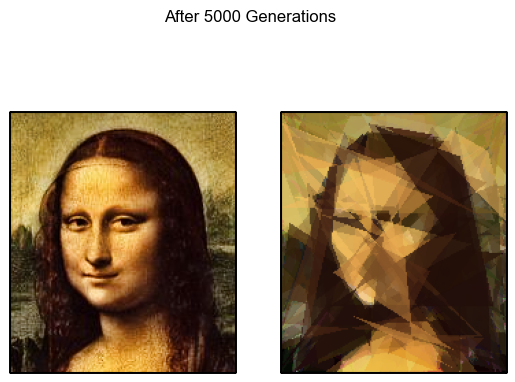

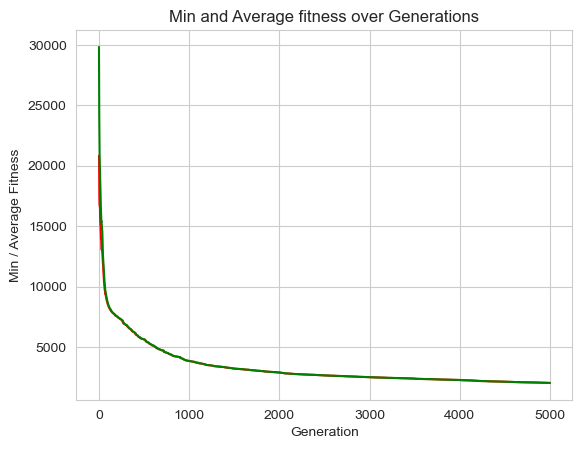

In [5]:
# создание оригинального изображения:
imageTest = ImageTest("images/Mona_Lisa_head.png", POLYGON_SIZE)

toolbox = base.Toolbox()

# определение минимизирующей стратегии приспособления:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

# определение оператора индивидуума:
creator.create("Individual", list, fitness=creator.FitnessMin)

# функция, которая порождает случайные вещественные числа, равномерно распределенные в заданном диапазоне
def randomFloat(low, up):
    return [random.uniform(l, u) for l, u in zip([low] * NUM_OF_PARAMS, [up] * NUM_OF_PARAMS)]

# определение оператора, возвращающего список случайных чисел типа float:
toolbox.register("attrFloat", randomFloat, BOUNDS_LOW, BOUNDS_HIGH)

# оператор, который заполняет экземпляр индивидуума:
toolbox.register("individualCreator",
                 tools.initIterate,
                 creator.Individual,
                 toolbox.attrFloat)

# определение оператора, который генерирует лист индивидуумов:
toolbox.register("populationCreator",
                 tools.initRepeat,
                 list,
                 toolbox.individualCreator)


# вычисление степени различия
def getDiff(individual):
    return imageTest.getDifference(individual, DIFFERENCE_METHOD),

toolbox.register("evaluate", getDiff)


# генетические операторы:
toolbox.register("select", tools.selTournament, tournsize=2)

toolbox.register("mate",
                 tools.cxSimulatedBinaryBounded,
                 low=BOUNDS_LOW,
                 up=BOUNDS_HIGH,
                 eta=CROWDING_FACTOR)

toolbox.register("mutate",
                 tools.mutPolynomialBounded,
                 low=BOUNDS_LOW,
                 up=BOUNDS_HIGH,
                 eta=CROWDING_FACTOR,
                 indpb=1.0/NUM_OF_PARAMS)


# сохранение лучшего изображения каждые 100 поколений:
def saveImage(gen, polygonData):

    if gen % 100 == 0:

        # создание папки, если она не существует:
        folder = "images/results/run-{}-{}-{}".format(POLYGON_SIZE, NUM_OF_POLYGONS, DIFFERENCE_METHOD)
        if not os.path.exists(folder):
            os.makedirs(folder)

        # сохранение изображения в папке:
        imageTest.saveImage(polygonData,
                            "{}/after-{}-gen.png".format(folder, gen),
                            "After {} Generations".format(gen))

# Генетический алгоритм:
def genetic_image_reconstruction():

    # создание начального поколения (поколение 0):
    population = toolbox.populationCreator(n=POPULATION_SIZE)

    # подготовка объекта статистики:
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", numpy.min)
    stats.register("avg", numpy.mean)

    # определение объекта зала славы:
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)


    # выполнение генетического алгоритма с элитизмом и функцией обратного вызова 'saveImage':
    population, logbook = eaSimpleWithElitismAndCallback(population,
                                                      toolbox,
                                                      cxpb=P_CROSSOVER,
                                                      mutpb=P_MUTATION,
                                                      ngen=MAX_GENERATIONS,
                                                      callback=saveImage,
                                                      stats=stats,
                                                      halloffame=hof,
                                                      verbose=True)

    # вывод лучшего найденного решения:
    best = hof.items[0]
    print()
    print("Best Solution = ", best)
    print("Best Score = ", best.fitness.values[0])
    print()

    # вывод лучшего изображения:
    imageTest.plotImages(imageTest.polygonDataToImage(best))

    # извлечение статистики:
    minFitnessValues, meanFitnessValues = logbook.select("min", "avg")

    # построение статистических данных:
    sns.set_style("whitegrid")
    plt.figure("Stats:")
    plt.plot(minFitnessValues, color='red')
    plt.plot(meanFitnessValues, color='green')
    plt.xlabel('Generation')
    plt.ylabel('Min / Average Fitness')
    plt.title('Min and Average fitness over Generations')

    # отображение статистических данных:
    plt.show()

genetic_image_reconstruction()